# TiagoCuri - RM567016
## Fase 3 - Capítulo 10

In [ ]:
# Análise exploratória (EDA básica)

import pandas as pd

path = "Atividade_Cap10_produtos_agricolas.csv"
df = pd.read_csv(path)

df.head()

print("\nShape:")
print(df.shape)

print("\nInfo:")
print(df.info())

print("\nMédia de nulos por coluna:")
print(df.isna().mean())

print("\nDescrição:")
print(df.describe().T)

print("\nQuantidade por cultura:")
print(df['label'].value_counts())

print("\nQuantidade relativa por cultura:")
print(df['label'].value_counts(normalize=True) * 100)






In [ ]:
# EDA com Matriz de Correlação entre as propriedades

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

num_columns = df.select_dtypes(include=np.number).columns.to_list()
print(num_columns)

df['label'].unique()

print("Correlation Matrix")
corr = df[num_columns].corr()
print(corr)

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlação - variáveis numéricas")
plt.tight_layout()
plt.show()


In [ ]:
# 1. histogramas (apenas) das variáveis numéricas
plt.figure(figsize=(14, 10))

for idx, col in enumerate(num_columns):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribuição de {col}")

plt.tight_layout()
plt.show()

# 2. boxplots para identificar outliers e amplitude das variaveis
plt.figure(figsize=(14, 10))

for idx, col in enumerate(num_columns):
    plt.subplot(3, 3, idx + 1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

# 3. heatmap de correlação
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()


# 4. temperatura × umidade por cultura
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x="temperature",
    y="humidity",
    hue="label",
    palette="tab20",
    s=60,
    alpha=0.8
)
plt.title("Temperatura vs. Umidade por Cultura")
plt.show()

# 5. boxplot comparando nutrientes por cultura
plt.figure(figsize=(14, 8))
df_melt_npk = df.melt(id_vars="label", value_vars=["N", "P", "K"])
sns.boxplot(data=df_melt_npk, x="variable", y="value", hue="label")
plt.title("Distribuição de N, P e K por Cultura")
plt.show()




In [ ]:
# “Perfil ideal” de solo/clima para as plantações (pt. 3)

# Nesta etapa, a ideia foi montar um “perfil ideal” de solo e clima usando as estatísticas básicas do dataset: coisas como média, mediana e a faixa onde a maior parte dos valores realmente se concentra. Isso dá uma noção bem simples de quais condições aparecem com mais frequência no conjunto de dados: temperatura moderada, umidade relativamente alta, níveis medianos de nutrientes, pH levemente ácido e uma precipitação que não é nem baixa nem extrema.

perfil_mean = df[num_columns].mean()
perfil_median = df[num_columns].median()

display(perfil_mean.to_frame("mean"))
display(perfil_median.to_frame("median"))

perfil_iqr = df[num_columns].describe().loc[["25%", "50%", "75%"]]
print(perfil_iqr)

# aqui, comparei três culturas com esse perfil geral. para isso, usei gráficos (como radar, boxplots e scatterplots) e também calculei a distância entre cada cultura e o “perfil ideal”. a ideia é enxergar visualmente e numericamente quem está mais próximo do ambiente médio da base e quem depende de condições mais específicas.
# essa comparação ajuda a perceber rapidamente que cada cultura tem suas próprias preferências; algumas pedem mais nutrientes, outras gostam de mais chuva ou mais calor, e dá uma noção mais clara de como elas se posicionam dentro desse cenário geral.
culturas = ["rice", "mango", "coffee"]

df_tres = df[df["label"].isin(culturas)]
df_tres.head()

# medias das culturas selecionadas
medias_culturas = df_tres.groupby("label")[num_columns].mean()
print(medias_culturas)

# comparação individual: Boxplots das três culturas contra o dataset inteiro
plt.figure(figsize=(16, 12))

for idx, col in enumerate(num_columns):
    plt.subplot(3, 3, idx + 1)
    sns.boxplot(data=df, y=col, color="lightgray")
    sns.stripplot(data=df_tres, x="label", y=col, hue="label", dodge=True, alpha=0.6)
    plt.title(f"{col} — Comparação culturas selecionadas")
    plt.xlabel("")

plt.tight_layout()
plt.show()

# distância euclidiana das culturas ao perfil ideal 
from sklearn.metrics import pairwise_distances
import numpy as np

distancias = {}

for cultura in culturas:
    vetor_cultura = medias_culturas.loc[cultura].values.reshape(1, -1)
    vetor_ideal = perfil_mean.values.reshape(1, -1)
    dist = pairwise_distances(vetor_cultura, vetor_ideal, metric="euclidean")[0][0]
    distancias[cultura] = dist

print(distancias)

# heatmap das diferenças absolutas entre culturas e perfil ideal
diferencas = (medias_culturas - perfil_mean).abs()

plt.figure(figsize=(10, 6))
sns.heatmap(diferencas, annot=True, cmap="viridis", fmt=".2f")
plt.title("Diferença Absoluta: Culturas vs Perfil Ideal")
plt.show()









In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# usa XGBoost se instalado
try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

# para warnings chatões
import warnings
warnings.filterwarnings("ignore")


In [ ]:

X = df[num_columns]
y = df["label"]

# split treino/teste 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# logistic Regression (multinomial Softmax)

modelo_lr = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500
)

modelo_lr.fit(X_train_scaled, y_train)

pred_lr = modelo_lr.predict(X_test_scaled)

print("Accuracy (Logistic Regression):", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))


In [ ]:
# KNN

modelo_knn = KNeighborsClassifier(n_neighbors=7)

modelo_knn.fit(X_train_scaled, y_train)

pred_knn = modelo_knn.predict(X_test_scaled)

print("Accuracy (KNN):", accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))


In [ ]:
# decision tree

modelo_tree = DecisionTreeClassifier(
    max_depth=10,
    random_state=42
)

modelo_tree.fit(X_train, y_train)

pred_tree = modelo_tree.predict(X_test)

print("Accuracy (Decision Tree):", accuracy_score(y_test, pred_tree))
print(classification_report(y_test, pred_tree))


In [ ]:
# random forest

modelo_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

modelo_rf.fit(X_train, y_train)

pred_rf = modelo_rf.predict(X_test)

print("Accuracy (Random Forest):", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


In [ ]:
# XGBoost OU Gradient Boosting

if xgb_available:
    modelo_xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="multi:softmax",
        eval_metric="mlogloss"
    )

    modelo_xgb.fit(X_train, y_train)
    pred_xgb = modelo_xgb.predict(X_test)

    print("Accuracy (XGBoost):", accuracy_score(y_test, pred_xgb))
    print(classification_report(y_test, pred_xgb))
else:
    print("XGBoost não instalado — usando GradientBoostingClassifier.")

    modelo_gb = GradientBoostingClassifier()
    modelo_gb.fit(X_train, y_train)

    pred_gb = modelo_gb.predict(X_test)

    print("Accuracy (Gradient Boosting):", accuracy_score(y_test, pred_gb))
    print(classification_report(y_test, pred_gb))


Random Forest


<Figure size 1400x1200 with 0 Axes>

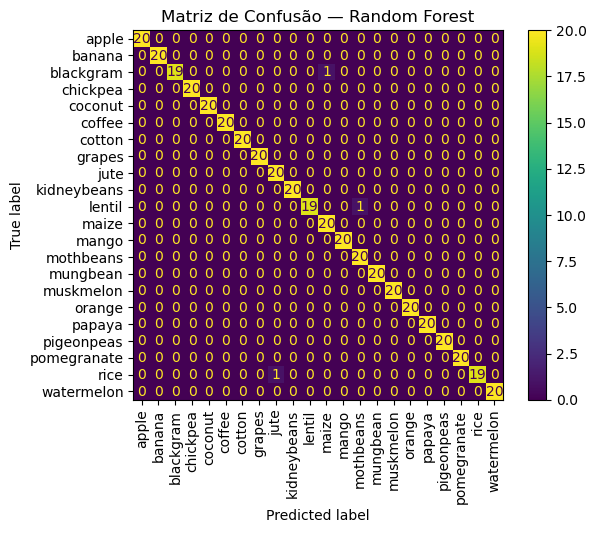

In [ ]:
# comparação de todos os modelos (tabela final)

resultados = {
    "Logistic Regression": accuracy_score(y_test, pred_lr),
    "KNN": accuracy_score(y_test, pred_knn),
    "Decision Tree": accuracy_score(y_test, pred_tree),
    "Random Forest": accuracy_score(y_test, pred_rf)
}

if xgb_available:
    resultados["XGBoost"] = accuracy_score(y_test, pred_xgb)
else:
    resultados["Gradient Boosting"] = accuracy_score(y_test, pred_gb)

pd.DataFrame(resultados, index=["accuracy"]).T

# descobrir o melhor modelo baseado em accuracy
melhor = max(resultados, key=resultados.get)
print(melhor)

# plot da matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

if melhor == "Logistic Regression":
    modelo, pred = modelo_lr, pred_lr
elif melhor == "KNN":
    modelo, pred = modelo_knn, pred_knn
elif melhor == "Decision Tree":
    modelo, pred = modelo_tree, pred_tree
elif melhor == "Random Forest":
    modelo, pred = modelo_rf, pred_rf
elif melhor == "XGBoost":
    modelo, pred = modelo_xgb, pred_xgb
else:
    modelo, pred = modelo_gb, pred_gb

plt.figure(figsize=(14, 12))
disp = ConfusionMatrixDisplay.from_predictions(y_test, pred, xticks_rotation=90)
plt.title(f"Matriz de Confusão — {melhor}")
plt.show()





In [ ]:
# Conclusão do Trabalho

# Este projeto teve como objetivo explorar a base de dados de condições agrícolas, entender o comportamento das variáveis de solo e clima e, por fim, treinar modelos capazes de prever qual cultura seria mais adequada para cada cenário. No geral, o dataset ajudou bastante, porque já veio limpo, balanceado e com variáveis bem distribuídas, o que facilitou tanto a análise quanto a construção dos modelos.
# Na parte exploratória, deu para perceber que as condições presentes no dataset representam um ambiente “médio” bastante versátil: temperaturas moderadas, umidade relativamente alta e solos com níveis variados de nutrientes. A comparação entre o perfil geral e algumas culturas específicas mostrou que cada uma delas segue seu próprio padrão: algumas exigem mais nutrientes, outras preferem ambientes mais úmidos, outras funcionam melhor em pH mais ácido ou mais alcalino. Esses gráficos deixam claro que as culturas não seguem um único modelo e que há bastante diversidade dentro do tema.
# Na parte preditiva, os modelos de árvore, especialmente Random Forest e Gradient Boosting/XGBoost tiveram o melhor desempenho. Isso já era esperado, porque árvores costumam lidar muito bem com dados numéricos variados e relações não lineares entre as variáveis. Métodos baseados em distância ou regressão funcionaram, mas tiveram limitações. Logistic Regression, por exemplo, não captou tão bem as fronteiras de decisão, e o KNN depende muito da escala dos dados. Ainda assim, todos foram úteis para comparar abordagens diferentes.
